In [1]:
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.optim as optim
from sklearn.model_selection import ParameterSampler

# GPU 장치 확인 및 설정
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

# 데이터 로드
data = pd.read_csv('../document/oneship.csv')

# 필요 없는 열 제거
data = data.drop(columns=['id', 'msg_type', 'mmsi', 'status', 'created_at', 'datetime'])

# 타겟 변수와 독립 변수
target_columns = ['lat', 'lon']  # 타겟 변수
independent_columns = list(data.columns)  # 모든 열을 독립변수로 포함

# 시계열 데이터 변환
time_steps = 50
X, y = [], []
for i in range(len(data) - time_steps):
    # 입력 데이터: 모든 독립변수 포함
    X.append(data.iloc[i:i+time_steps][independent_columns].values)
    # 출력 데이터: 타겟 변수만 포함
    y.append(data.iloc[i+time_steps][target_columns].values)
X, y = np.array(X, dtype=np.float32), np.array(y, dtype=np.float32)

print(f"X 크기: {X.shape}, y 크기: {y.shape}")


Using device: cuda
X 크기: (582, 50, 30), y 크기: (582, 2)


In [2]:
# 데이터 분할
train_size = int(len(X) * 0.7)
val_size = int(len(X) * 0.15)
X_train, X_val, X_test = X[:train_size], X[train_size:train_size + val_size], X[train_size + val_size:]
y_train, y_val, y_test = y[:train_size], y[train_size:train_size + val_size], y[train_size + val_size:]

print(f"Train 데이터 크기: {X_train.shape}, {y_train.shape}")
print(f"Validation 데이터 크기: {X_val.shape}, {y_val.shape}")
print(f"Test 데이터 크기: {X_test.shape}, {y_test.shape}")


Train 데이터 크기: (407, 50, 30), (407, 2)
Validation 데이터 크기: (87, 50, 30), (87, 2)
Test 데이터 크기: (88, 50, 30), (88, 2)


In [3]:
# Tensor 변환 및 GPU로 이동
X_train_tensor = torch.tensor(X_train, dtype=torch.float32).to(device)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32).to(device)
X_val_tensor = torch.tensor(X_val, dtype=torch.float32).to(device)
y_val_tensor = torch.tensor(y_val, dtype=torch.float32).to(device)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32).to(device)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32).to(device)

In [4]:
# LSTM 모델 정의
class LSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, output_size, dropout):
        super(LSTMModel, self).__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers, batch_first=True, dropout=dropout)
        self.fc = nn.Linear(hidden_size, output_size)

    def forward(self, x):
        out, _ = self.lstm(x)
        out = self.fc(out[:, -1, :])  # 마지막 타임스텝의 출력
        return out

# 하이퍼파라미터 샘플링 범위
param_dist = {
    'hidden_size': [32, 64, 128, 256, 512],
    'num_layers': [1, 2, 3, 4],
    'learning_rate': [0.001, 0.01, 0.0001],
    'batch_size': [16, 32, 64, 128],
    'dropout': [0.0, 0.2, 0.5]
}

# 랜덤 샘플링
n_iter = 20
random_params = list(ParameterSampler(param_dist, n_iter=n_iter, random_state=42))

# 랜덤 서치 실행
best_loss = float('inf')
best_params = None

for params in random_params:
    hidden_size = params['hidden_size']
    num_layers = params['num_layers']
    learning_rate = params['learning_rate']
    batch_size = params['batch_size']
    dropout = params['dropout']

    # 모델 초기화
    model = LSTMModel(
        input_size=X_train.shape[2],
        hidden_size=hidden_size,
        num_layers=num_layers,
        output_size=2,
        dropout=dropout
    ).to(device)

    criterion = nn.MSELoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)

    # 배치 학습
    model.train()
    train_loss = 0.0
    for i in range(0, len(X_train_tensor), batch_size):
        X_batch = X_train_tensor[i:i+batch_size]
        y_batch = y_train_tensor[i:i+batch_size]

        optimizer.zero_grad()
        outputs = model(X_batch)
        loss = criterion(outputs, y_batch)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()

    # 평균 손실 계산
    avg_loss = train_loss / (len(X_train_tensor) // batch_size)
    print(f"Params: {params}, Loss: {avg_loss:.4f}")

    # 최적 파라미터 저장
    if avg_loss < best_loss:
        best_loss = avg_loss
        best_params = params

print(f"최적 파라미터: {best_params}, 손실: {best_loss:.4f}")

c:\Users\user\anaconda3\envs\py3_11\Lib\site-packages\torch\nn\modules\rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.5 and num_layers=1
  warnings.warn(


Params: {'num_layers': 1, 'learning_rate': 0.01, 'hidden_size': 256, 'dropout': 0.5, 'batch_size': 32}, Loss: 8050.5524
Params: {'num_layers': 3, 'learning_rate': 0.001, 'hidden_size': 512, 'dropout': 0.2, 'batch_size': 32}, Loss: 8355.3309
Params: {'num_layers': 3, 'learning_rate': 0.01, 'hidden_size': 512, 'dropout': 0.0, 'batch_size': 16}, Loss: 4642.3008
Params: {'num_layers': 3, 'learning_rate': 0.01, 'hidden_size': 64, 'dropout': 0.0, 'batch_size': 32}, Loss: 8930.8213
Params: {'num_layers': 2, 'learning_rate': 0.0001, 'hidden_size': 128, 'dropout': 0.2, 'batch_size': 64}, Loss: 10471.7739
Params: {'num_layers': 2, 'learning_rate': 0.01, 'hidden_size': 32, 'dropout': 0.2, 'batch_size': 16}, Loss: 8609.9927
Params: {'num_layers': 4, 'learning_rate': 0.001, 'hidden_size': 32, 'dropout': 0.2, 'batch_size': 16}, Loss: 9289.1173
Params: {'num_layers': 2, 'learning_rate': 0.001, 'hidden_size': 128, 'dropout': 0.5, 'batch_size': 16}, Loss: 8848.0321
Params: {'num_layers': 1, 'learning_r

c:\Users\user\anaconda3\envs\py3_11\Lib\site-packages\torch\nn\modules\rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.2 and num_layers=1
  warnings.warn(


Params: {'num_layers': 4, 'learning_rate': 0.001, 'hidden_size': 256, 'dropout': 0.0, 'batch_size': 16}, Loss: 8200.6014
Params: {'num_layers': 2, 'learning_rate': 0.01, 'hidden_size': 256, 'dropout': 0.2, 'batch_size': 16}, Loss: 5735.7598
Params: {'num_layers': 3, 'learning_rate': 0.0001, 'hidden_size': 32, 'dropout': 0.2, 'batch_size': 64}, Loss: 10509.7962
Params: {'num_layers': 1, 'learning_rate': 0.01, 'hidden_size': 128, 'dropout': 0.5, 'batch_size': 32}, Loss: 8903.9969


c:\Users\user\anaconda3\envs\py3_11\Lib\site-packages\torch\nn\modules\rnn.py:123: UserWarning: dropout option adds dropout after all but last recurrent layer, so non-zero dropout expects num_layers greater than 1, but got dropout=0.5 and num_layers=1
  warnings.warn(


Params: {'num_layers': 3, 'learning_rate': 0.001, 'hidden_size': 128, 'dropout': 0.2, 'batch_size': 16}, Loss: 8731.7084
Params: {'num_layers': 4, 'learning_rate': 0.001, 'hidden_size': 128, 'dropout': 0.2, 'batch_size': 128}, Loss: 11969.4235
Params: {'num_layers': 4, 'learning_rate': 0.01, 'hidden_size': 64, 'dropout': 0.2, 'batch_size': 32}, Loss: 8893.8322
Params: {'num_layers': 2, 'learning_rate': 0.0001, 'hidden_size': 128, 'dropout': 0.0, 'batch_size': 32}, Loss: 9728.1420
최적 파라미터: {'num_layers': 3, 'learning_rate': 0.01, 'hidden_size': 512, 'dropout': 0.0, 'batch_size': 16}, 손실: 4642.3008


In [5]:
# 최적 파라미터
best_params = {'num_layers': 3, 'learning_rate': 0.01, 'hidden_size': 512, 'dropout': 0.0, 'batch_size': 16}

best_model = LSTMModel(
    input_size=X_train.shape[2],
    hidden_size=best_params['hidden_size'],
    num_layers=best_params['num_layers'],
    output_size=2,
    dropout=best_params['dropout']
).to(device)

criterion = nn.SmoothL1Loss()
optimizer = optim.Adam(best_model.parameters(), lr=best_params['learning_rate'])



In [6]:
# 학습 루프
num_epochs = 100
train_loss_list = []

best_model.train()
for epoch in range(num_epochs):
    train_loss = 0.0
    for i in range(0, len(X_train_tensor), best_params['batch_size']):
        X_batch = X_train_tensor[i:i+best_params['batch_size']]
        y_batch = y_train_tensor[i:i+best_params['batch_size']]

        optimizer.zero_grad()
        outputs = best_model(X_batch)
        loss = criterion(outputs, y_batch)
        loss.backward()
        optimizer.step()

        train_loss += loss.item()

    avg_train_loss = train_loss / (len(X_train_tensor) // best_params['batch_size'])
    train_loss_list.append(avg_train_loss)
    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {avg_train_loss:.4f}")

Epoch [1/100], Loss: 53.3735
Epoch [2/100], Loss: 12.8421
Epoch [3/100], Loss: 1.4894
Epoch [4/100], Loss: 0.1050
Epoch [5/100], Loss: 0.0106
Epoch [6/100], Loss: 0.0037
Epoch [7/100], Loss: 0.0043
Epoch [8/100], Loss: 0.0041
Epoch [9/100], Loss: 0.0025
Epoch [10/100], Loss: 0.0018
Epoch [11/100], Loss: 0.0019
Epoch [12/100], Loss: 0.0021
Epoch [13/100], Loss: 0.0025
Epoch [14/100], Loss: 0.0031
Epoch [15/100], Loss: 0.0038
Epoch [16/100], Loss: 0.0046
Epoch [17/100], Loss: 0.0051
Epoch [18/100], Loss: 0.0049
Epoch [19/100], Loss: 0.0041
Epoch [20/100], Loss: 0.0031
Epoch [21/100], Loss: 0.0024
Epoch [22/100], Loss: 0.0021
Epoch [23/100], Loss: 0.0020
Epoch [24/100], Loss: 0.0020
Epoch [25/100], Loss: 0.0021
Epoch [26/100], Loss: 0.0022
Epoch [27/100], Loss: 0.0025
Epoch [28/100], Loss: 0.0029
Epoch [29/100], Loss: 0.0034
Epoch [30/100], Loss: 0.0040
Epoch [31/100], Loss: 0.0046
Epoch [32/100], Loss: 0.0051
Epoch [33/100], Loss: 0.0055
Epoch [34/100], Loss: 0.0056
Epoch [35/100], Loss:

In [7]:
# 테스트 데이터 평가
best_model.eval()
test_loss = 0.0
with torch.no_grad():
    y_pred = best_model(X_test_tensor).detach().cpu().numpy()  # 예측 값
    y_true = y_test  # 실제 값

    for i in range(0, len(X_test_tensor), best_params['batch_size']):
        X_batch = X_test_tensor[i:i+best_params['batch_size']]
        y_batch = y_test_tensor[i:i+best_params['batch_size']]
        outputs = best_model(X_batch)
        loss = criterion(outputs, y_batch)
        test_loss += loss.item()

avg_test_loss = test_loss / (len(X_test_tensor) // best_params['batch_size'])
print(f"테스트 손실(MSE): {avg_test_loss:.4f}")


테스트 손실(MSE): 0.0124


In [13]:
# 예측 값과 실제 값 비교
comparison = pd.DataFrame({
    'True Lat': y_true[:, 0],
    'True Lon': y_true[:, 1],
    'Predicted Lat': y_pred[:, 0],
    'Predicted Lon': y_pred[:, 1]
})
print(comparison)

     True Lat    True Lon  Predicted Lat  Predicted Lon
0   34.929981  129.384277      34.959724      129.42366
1   34.929485  129.383926      34.959724      129.42366
2   34.928997  129.383575      34.959724      129.42366
3   34.928463  129.383209      34.959724      129.42366
4   34.927532  129.382568      34.959724      129.42366
..        ...         ...            ...            ...
83  34.755337  129.261215      34.959724      129.42366
84  34.754684  129.260269      34.959724      129.42366
85  34.753899  129.259079      34.959724      129.42366
86  34.753166  129.258026      34.959724      129.42366
87  34.752876  129.257599      34.959724      129.42366

[88 rows x 4 columns]


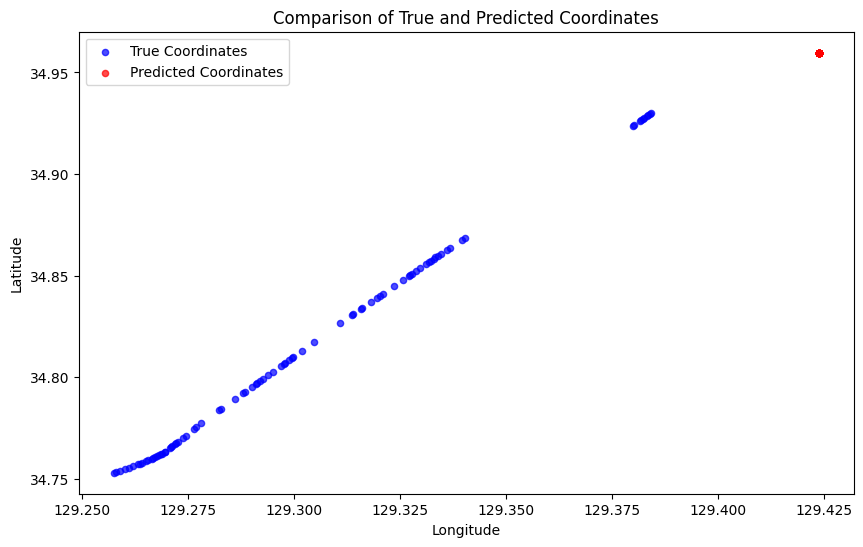

In [9]:
import matplotlib.pyplot as plt

# 실제 값과 예측 값 산포도
plt.figure(figsize=(10, 6))
plt.scatter(y_true[:, 1], y_true[:, 0], label='True Coordinates', alpha=0.7, c='blue', s=20)  # 실제 좌표
plt.scatter(y_pred[:, 1], y_pred[:, 0], label='Predicted Coordinates', alpha=0.7, c='red', s=20)  # 예측 좌표
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('Comparison of True and Predicted Coordinates')
plt.legend()
plt.show()


              lat         lon
count  632.000000  632.000000
mean    35.073405  129.409017
std      0.139600    0.047837
min     34.752878  129.257602
25%     34.985586  129.407479
50%     35.092411  129.413100
75%     35.174924  129.440125
max     35.380102  129.458468


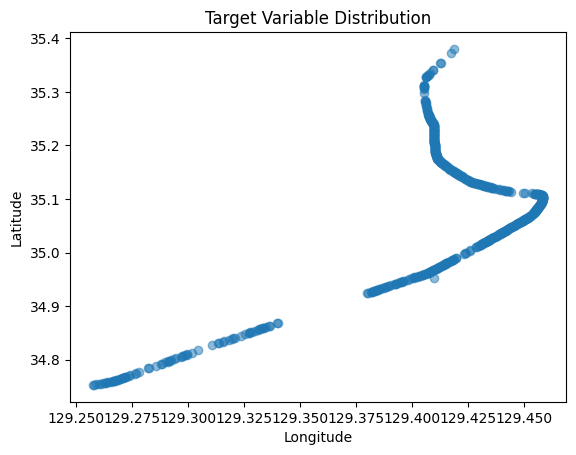

In [10]:
# 타겟 변수의 분포 확인
print(data[['lat', 'lon']].describe())

# 타겟 변수의 시각화
import matplotlib.pyplot as plt
plt.scatter(data['lon'], data['lat'], alpha=0.5)
plt.xlabel('Longitude')
plt.ylabel('Latitude')
plt.title('Target Variable Distribution')
plt.show()


In [11]:
# 입력 데이터 샘플 확인
print("독립변수 데이터 요약:")
print(pd.DataFrame(X.reshape(-1, X.shape[-1])).describe())



독립변수 데이터 요약:
                 0             1        2             3             4   \
count  29100.000000  29100.000000  29100.0  29100.000000  29100.000000   
mean       0.040238      0.075282      0.0    129.415161     35.076878   
std        0.248131      0.010560      0.0      0.039893      0.120572   
min       -0.984375      0.055906      0.0    129.258026     34.753166   
25%        0.007812      0.070079      0.0    129.409409     35.011870   
50%        0.007812      0.071654      0.0    129.416107     35.092804   
75%        0.007812      0.073228      0.0    129.442062     35.167963   
max        1.000000      0.097638      0.0    129.458466     35.380100   

                 5             6             7             8             9   \
count  29100.000000  29100.000000  29100.000000  29100.000000  29100.000000   
mean       0.511449      0.363559      0.145902      0.791596      0.429310   
std        0.059904      0.038493      0.194106      0.203752      0.166232   
min 

In [12]:

# 타겟 변수의 분포 확인
print("타겟 변수 분포:")
print(pd.DataFrame(y, columns=['lat', 'lon']).describe())

타겟 변수 분포:
              lat         lon
count  582.000000  582.000000
mean    35.054817  129.409149
std      0.129115    0.049845
min     34.752876  129.257599
25%     34.975043  129.409424
50%     35.079834  129.416069
75%     35.150401  129.441998
max     35.246914  129.458466
